# GHCNd station data

These are data from Global Historical Climatology Network daily (GHCNd)

> https://www.ncei.noaa.gov/products/land-based-station/global-historical-climatology-network-daily
>
> The Global Historical Climatology Network daily (GHCNd) is an integrated database of daily climate summaries from land surface stations across the globe. GHCNd is made up of daily climate records from numerous sources that have been integrated and subjected to a common suite of quality assurance reviews.
>
> GHCNd contains records from more than 100,000 stations in 180 countries and territories. NCEI provides numerous daily variables, including maximum and minimum temperature, total daily precipitation, snowfall, and snow depth. About half the stations only report precipitation. Both record length and period of record vary by station and cover intervals ranging from less than a year to more than 175 years.


In [11]:
import time
import pandas as pd
import geopandas as gpd
import contextily as cx
import matplotlib.pyplot as plt
import yaml
import os
import sys

ghcnd_stations_url = 'https://www.ncei.noaa.gov/data/global-historical-climatology-network-daily/doc/ghcnd-stations.txt'
ghcnd_stations_url = '/home/javi/Research/cordex-fps-urb-rcc/git/cordex-fps-urb-rcc/ghcnd-stations.txt'
ghcnd_stations_column_names = ['code', 'lat', 'lon', 'elev', 'name', 'net', 'numcode']
ghcnd_stations_column_widths = [   11,     9,    10,      7,     34,     4,       10 ]

In [2]:
df = pd.read_fwf(ghcnd_stations_url, header = 0,
  widths = ghcnd_stations_column_widths,
  names = ghcnd_stations_column_names
)
ghcnd_stations = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.lon, df.lat), crs = 'EPSG:4326')

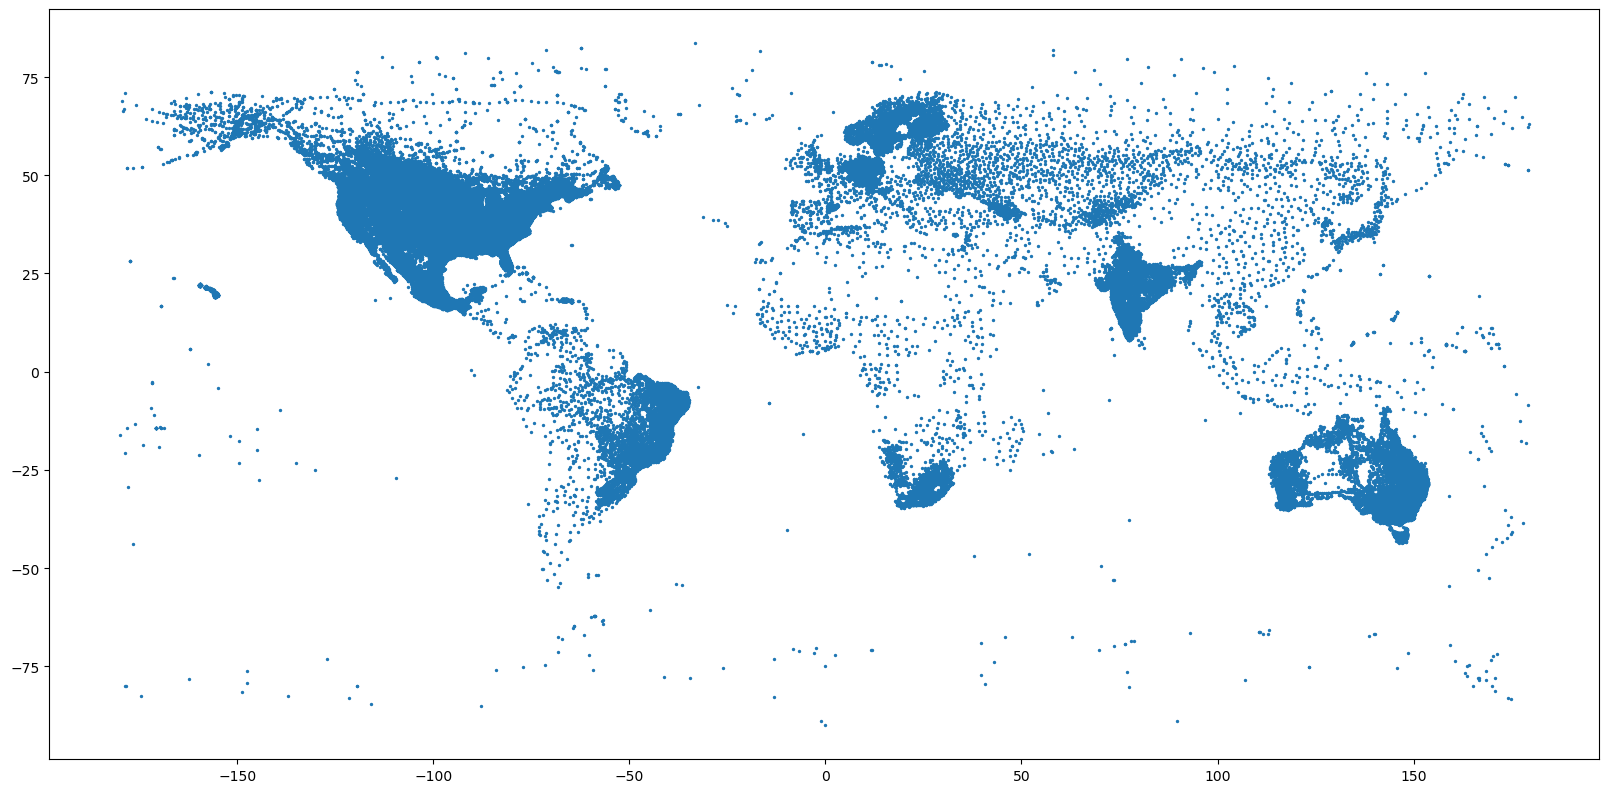

In [3]:
p = ghcnd_stations.plot(figsize=(20,10), markersize=2)

## Read city databases

Read in OECC city info

In [4]:
df = pd.read_csv('city_info_out.csv', comment='#',
  dtype = dict(domain = 'category', ktype = 'category')
)
city_info = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.lon, df.lat), crs = 'EPSG:4326')

and the names of the currently selected cities

In [5]:
with open('selected_cities.yaml') as fp:
  selected = yaml.load(fp, Loader=yaml.FullLoader)['cordex_core_analysis']

## Plot nearby stations (functions)

By default, we select those within half a degree around the city center

In [6]:
def nearby_stations(city, maxdis = 0.5):
  citydf = city_info.query(f'city == "{city}"').squeeze()
  nearby_stations = ghcnd_stations[ghcnd_stations.distance(citydf.geometry) < maxdis].to_crs(epsg=3857)
  return(nearby_stations)

def plot_nearby_stations(city, nearby_stations, dest, maxdis = 0.5, highlight=pd.DataFrame()):
  citydf = city_info.query(f'city == "{city}"').squeeze()
  img, ext = cx.bounds2img(
    citydf.lon - maxdis, citydf.lat - maxdis, citydf.lon + maxdis, citydf.lat + maxdis, ll=True,
    # source=cx.providers.Stamen.Toner
    # source=cx.providers.OpenStreetMap.Mapnik
  )
  ax = nearby_stations.plot(figsize=(15,15), color = 'red')
  for x, y, label in zip(nearby_stations.geometry.x, nearby_stations.geometry.y, nearby_stations.name):
    ax.annotate(label, xy=(x, y), xytext=(10, -10), textcoords='offset points', color = 'red')
  if not highlight.empty:
    highlight.plot(ax=ax, color='blue', edgecolor='white', zorder=100)
  for x, y, label in zip(highlight.geometry.x, highlight.geometry.y, highlight.name):
    ax.annotate(label, xy=(x, y), xytext=(10, -10), textcoords='offset points', color = 'blue', fontsize=20)
  ax.imshow(img, extent=ext)
  plt.title(city)
  plt.savefig(dest  + '/Nearby_stations_cycle_' + city + '.png', facecolor='white')

  #cx.add_basemap(ax, reset_extent = False)

def get_ghcnd_df(code):
    baseurl = 'http://meteo.unican.es/work/chus/ghcnd/data'
    try:
      rval = pd.read_csv(f'{baseurl}/{code[0]}/{code}.csv.gz', compression='gzip', index_col='DATE', parse_dates=True)
    except:
      print(f'Problem downloading {code}')
      rval = pd.DataFrame()
    return(rval)

def available_vars(station):
  return(set(station.columns).intersection({'TMIN'}))
  #return(set(station.columns).intersection({'PRCP', 'TAVG', 'TMAX', 'TMIN', 'SNWD'}))

def plot_station_timeseries(city, stations, var = 'PRCP', v_records = 0.5, idate='1979-01-01', fdate='2014-12-31'):
  period = slice(idate, fdate)
  ndays = (pd.to_datetime(fdate)-pd.to_datetime(idate)).days
  valid_codes = []
  for stn_code in stations.code:
    stn_data = get_ghcnd_df(stn_code)
    if stn_data.empty:
      continue
    availvars = available_vars(stn_data)
    print(f'{stn_data.NAME[0]} {availvars}', end=' ')
    if var in availvars:
      valid_records = stn_data[var].loc[period].notna().sum()/ndays
      print(f'  {var} has {100*valid_records:.1f}% valid records in {idate} to {fdate}')
      if valid_records > v_records:
        plt.figure()
        stn_data[var].loc[period].plot(
          figsize=(14,3),
          xlim=(idate,fdate),
          title = f'{city} -- {stn_data.NAME[0]} ({100*valid_records:.0f}%)'
        )
        valid_codes.append(stn_code)
    else:
      print(f'  No {var}')
  return(stations[stations.code.isin(valid_codes)])

In [7]:
def plot_city(city_name, dest, maxdis = 0.5, v_records = 0.3):
  nearstat = nearby_stations(city_name, maxdis = maxdis)
  if not nearstat.empty:
    valid = plot_station_timeseries(city_name, nearstat, 'TMIN', v_records)
    plot_nearby_stations(city_name, nearstat, dest, maxdis= maxdis, highlight=valid)
  else:
    print('No nearby stations in GHCNd')

In [8]:
import warnings
warnings.filterwarnings('ignore') # Hide UserWarnings alerting on the approximate distance in geographic CRS

# Selected cities

For each city, surrounding GHCNd stations with valid values above 50% are shown as time series. The city map displaus all surrounding stations (in red) along with those meeting the valid data criterion (in blue).

Next cell contents generated by:

[Cairo](#Cairo) · [Lagos](#Lagos) · [Johannesburg](#Johannesburg) · [Luanda](#Luanda) · [Khartoum](#Khartoum) · [Sydney](#Sydney) · [Melbourne](#Melbourne) · [Mexico City](#Mexico-City) · [Moscow](#Moscow) · [Tashkent](#Tashkent) · [Tehran](#Tehran) · [Dhaka](#Dhaka) · [Beijing](#Beijing) · [Tokyo](#Tokyo) · [Chengdu](#Chengdu) · [Seoul](#Seoul) · [Shanghai](#Shanghai) · [Paris](#Paris) · [London](#London) · [Istanbul](#Istanbul) · [Berlin](#Berlin) · [Helsinki](#Helsinki) · [New York](#New-York) · [Chicago](#Chicago) · [Los Angeles](#Los-Angeles) · [Montreal](#Montreal) · [Toronto](#Toronto) · [Buenos Aires](#Buenos-Aires) · [Lima](#Lima) · [São Paulo](#São-Paulo) · [Santiago](#Santiago) · [Jakarta](#Jakarta) · [Quezon City [Manila]](#Quezon-City-[Manila]) · [Singapore](#Singapore) · [Mumbai](#Mumbai) · [Riyadh](#Riyadh) · [Delhi [New Delhi]](#Delhi-[New-Delhi]) · [Baghdad](#Baghdad)

## Main Loop

In [9]:
location = {
     'Mexico City' : dict(lon=-99.0833, lat=19.4667, domain = 'CAM-22', #1
                          vmin= -5, vmax = 5, valid_t = 0.8, maxdis = 0.5, vtmin = -10, vtmax = 10),
     'Buenos Aires' : dict(lon=-58.416, lat=-34.559, domain = 'SAM-22', #2
                           vmin= -3, vmax = 3, valid_t = 0.5, maxdis = 0.5, vtmin = -10, vtmax = 10),
     'New York' : dict(lon=-74.2261, lat=40.8858, domain = 'NAM-22',#3
                       vmin= -3, vmax = 3, valid_t = 0.5, maxdis = 0.5, vtmin = -10, vtmax = 10),
     'Sydney' : dict(lon=151.01810, lat=-33.79170, domain = 'AUS-22', #4
                     vmin= -3, vmax = 3, valid_t = 0.6, maxdis = 0.5, vtmin = -10, vtmax = 10),
     'Beijing' : dict(lon=116.41, lat=39.90, domain = 'EAS-22', #5
                      vmin= -3, vmax = 3, valid_t = 0.5, maxdis = 0.5, vtmin = -10, vtmax = 10),
     'Tokyo' : dict(lon = 139.84, lat = 35.65, domain = 'EAS-22', #6
                    vmin= -3, vmax = 3, valid_t = 0.5, maxdis = 0.5, vtmin = -10, vtmax = 10),
     'Jakarta' : dict(lon = 106.81, lat = -6.2, domain = 'SEA-22', #7
                      vmin= -3, vmax = 3, valid_t = 0.35, maxdis = 1, vtmin = -10, vtmax = 10), 
     'Johannesburg' : dict(lon=28.183, lat=-25.733, domain = 'AFR-22', #8
                           vmin= -3, vmax = 3, valid_t = 0.5, maxdis = 0.5, vtmin = -10, vtmax = 10), # Pretoria center station
     'Riyadh' : dict(lon=46.73300, lat=24.7000, domain = 'WAS-22', #9
                     vmin= -3, vmax = 3, valid_t = 0.5, maxdis = 0.5, vtmin = -10, vtmax = 10), #Urban frac
     'Berlin' : dict(lon=13.4039, lat=52.4683, domain = 'EUR-11', #10
                     vmin= -3, vmax = 3, valid_t = 0.5, maxdis = 1, vtmin = -10, vtmax = 10),
     'Paris' : dict(lon=  2.35, lat=48.85, domain = 'EUR-11',  #11
                    vmin= -3, vmax = 3, valid_t = 0.5, maxdis = 2, vtmin = -10, vtmax = 10), # Problems with the city (ucdb_city)
     'London' : dict(lon= -0.13, lat=51.50, domain = 'EUR-11', #12
                     vmin= -3, vmax = 3, valid_t = 0.5, maxdis = 1, vtmin = -10, vtmax = 10),
     'Madrid' : dict(lon= -3.70, lat=40.42, domain = 'EUR-11', #13
                     vmin= -3, vmax = 3, valid_t = 0.5, maxdis = 0.5, vtmin = -10, vtmax = 10),
     'Los Angeles': dict(lon = -118.24, lat = 34.05, domain = 'NAM-22', #14
                         vmin= -3, vmax = 3, valid_t = 0.5, maxdis = 1, vtmin = -10, vtmax = 10),
     'Montreal': dict(lon = -73.56, lat = 45.50, domain = 'NAM-22', #15
                      vmin= -3, vmax = 3, valid_t = 0.5, maxdis = 0.5, vtmin = -10, vtmax = 10),
}

In [12]:
dest = '/home/javi/Research/cordex-fps-urb-rcc/git/cordex-fps-urb-rcc/results/pictures/'
os.makedirs(dest,  exist_ok=True)

In [ ]:
for city in location.keys():
    plot_city(city, dest, maxdis = location[city]['maxdis'], v_records = location[city]['valid_t'])